# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and define constants

Import libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
from mpl_toolkits.mplot3d import Axes3D # Axes3D for 3D visualization
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import timeit                      # timing how long it takes to import libraries
from scipy.optimize import fsolve  # used for solving system of nonlin eqs. (particle intersections)
import warnings                    # used for particle intersections
# import time                        # timing how long it takes to import libraries

t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
# threshold_1 = 55 # for 36a
# threshold_1 = 99 # for 500nm_epoxy_2
# threshold_1 = 70 # for 500nm_epoxy_15
threshold_2 = 35 # for 36b
threshold_3 = 45 # for 36e
threshold_1 = 55 # for 36h

print(str(nm_per_pixel), "nm per pixel")
print(str(expected_radius), "nm is the expected particle radius")

1.7182130584192439 nm per pixel
100 nm is the expected particle radius


## 2. Setup

grayscale, gaussian blur, binary threshold, noise removel, dilation, distance transform

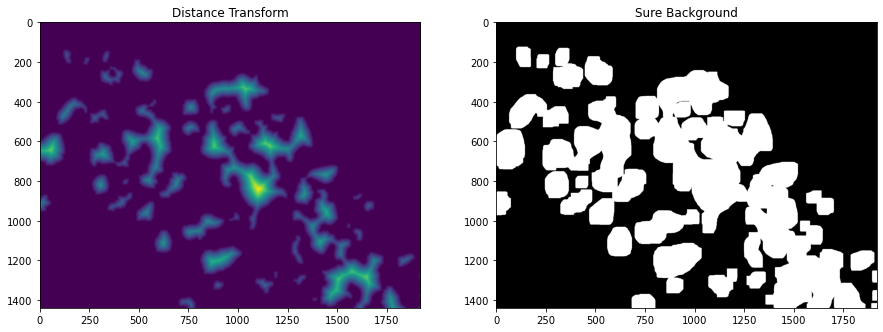

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

# IMAGE_NAME_1 = "TES-36a-cropped.tif"
# IMAGE_NAME_2 = "TES-36b-cropped.tif"
# IMAGE_NAME_3 = "TES-36e-cropped.tif"
IMAGE_NAME_1 = "TES-36h-cropped.tif"
# IMAGE_NAME_1 = "./500nm_epoxy/500nm_epoxy_2.jpg"
# IMAGE_NAME_1 = "./500nm_epoxy/500nm_epoxy_15.jpg"
# IMAGE_NAME_1 = "./500nm_epoxy/500nm_epoxy_22.jpg"

color_image_1, dist_transform_1, sure_bg_1 = setup(IMAGE_NAME_1, threshold_1, False)
# color_image_2, dist_transform_2, sure_bg_2 = setup(IMAGE_NAME_2, threshold_2, False)
# color_image_3, dist_transform_3, sure_bg_3 = setup(IMAGE_NAME_3, threshold_3, False)

## 3. Perform watershed and find contours

Find the threshold value that will break up agglomerates into individual particles

In [4]:
dist_transform_thresh_1 = get_watershed_threshold(dist_transform_1, sure_bg_1, color_image_1, expected_radius)
# dist_transform_thresh_2 = get_watershed_threshold(dist_transform_2, sure_bg_2, color_image_2, expected_radius)
# dist_transform_thresh_3 = get_watershed_threshold(dist_transform_3, sure_bg_3, color_image_3, expected_radius)
#print(dist_transform_thresh)

# print(dist_transform_thresh_1)

Get watershed markers

In [5]:
# watershed markers for finding particles (no agglomerates)
watershed_markers_1 = get_watershed_markers(dist_transform_1, dist_transform_thresh_1, sure_bg_1, color_image_1, False)
# watershed_markers_2 = get_watershed_markers(dist_transform_2, dist_transform_thresh_2, sure_bg_2, color_image_2, False)
# watershed_markers_3 = get_watershed_markers(dist_transform_3, dist_transform_thresh_3, sure_bg_3, color_image_3, False)

# watershed markers for finding agglomerates
agg_watershed_markers_1 = get_watershed_markers(dist_transform_1, 0.1, sure_bg_1, color_image_1, False)
# agg_watershed_markers_2 = get_watershed_markers(dist_transform_2, 0.1, sure_bg_2, color_image_2, False)
# agg_watershed_markers_3 = get_watershed_markers(dist_transform_3, 0.1, sure_bg_3, color_image_3, False)

Get contours

In [6]:
contour_colors_1, chords_color_copy_1 = get_contour_colors(watershed_markers_1, color_image_1)
# contour_colors_2, chords_color_copy_2 = get_contour_colors(watershed_markers_2, color_image_2)
# contour_colors_3, chords_color_copy_3 = get_contour_colors(watershed_markers_3, color_image_3)

agg_contour_colors_1, agg_chords_color_copy_1 = get_contour_colors(agg_watershed_markers_1, color_image_1)
# agg_contour_colors_2, agg_chords_color_copy_2 = get_contour_colors(agg_watershed_markers_2, color_image_2)
# agg_contour_colors_3, agg_chords_color_copy_3 = get_contour_colors(agg_watershed_markers_3, color_image_3)

# display_images([chords_color_copy_1, agg_chords_color_copy_1], ["Particle Contours", "Agglomerate Contours"], [1, 1])
# display_images([chords_color_copy_2, agg_chords_color_copy_2], ["Particle Contours", "Agglomerate Contours"], [1, 1])
# display_images([chords_color_copy_3, agg_chords_color_copy_3], ["Particle Contours", "Agglomerate Contours"], [1, 1])

## 4. Finding centerpoints, getting areas, and replacing agglomerates with particles

Finding centerpoints

In [7]:
particles_1 = find_centerpoints(contour_colors_1)
# particles_2 = find_centerpoints(contour_colors_2)
# particles_3 = find_centerpoints(contour_colors_3)

agg_particles_1 = find_centerpoints(agg_contour_colors_1)
# agg_particles_2 = find_centerpoints(agg_contour_colors_2)
# agg_particles_3 = find_centerpoints(agg_contour_colors_3)

Getting areas

In [8]:
particle_areas_1 = get_areas(watershed_markers_1)
# particle_areas_2 = get_areas(watershed_markers_2)
# particle_areas_3 = get_areas(watershed_markers_3)

agg_areas_1 = get_areas(agg_watershed_markers_1)
# agg_areas_2 = get_areas(agg_watershed_markers_2)
# agg_areas_3 = get_areas(agg_watershed_markers_3)

Replacing agglomerates with particles

In [9]:
# TODO: standardize way of referring to unique particle ID, here particle == color
# TODO: make v2 of function that defines agglomerate area by contour not min/max rectangle

merge_particles_1, merge_contour_colors_1 = match_images(particles_1, contour_colors_1, agg_particles_1, agg_contour_colors_1, agg_areas_1)
# merge_particles_2, merge_contour_colors_2 = match_images(particles_2, contour_colors_2, agg_particles_2, agg_contour_colors_2, agg_areas_2)
# merge_particles_3, merge_contour_colors_3 = match_images(particles_3, contour_colors_3, agg_particles_3, agg_contour_colors_3, agg_areas_3)
# [print(x, merge_particles[x]) for x in merge_particles.keys()]

## 5. Get long and short chord lengths

Get long chord lengths

In [10]:
long_pairs_1, merge_particles_1 = get_long_chord_lengths(merge_particles_1, merge_contour_colors_1)
# long_pairs_2, merge_particles_2 = get_long_chord_lengths(merge_particles_2, merge_contour_colors_2)
# long_pairs_3, merge_particles_3 = get_long_chord_lengths(merge_particles_3, merge_contour_colors_3)

# print(long_pairs)

Get short chord lengths

In [11]:
short_pairs_1, merge_particles_1 = get_short_chord_lengths(merge_particles_1, merge_contour_colors_1, long_pairs_1)
# short_pairs_2, merge_particles_2 = get_short_chord_lengths(merge_particles_2, merge_contour_colors_2, long_pairs_2)
# short_pairs_3, merge_particles_3 = get_short_chord_lengths(merge_particles_3, merge_contour_colors_3, long_pairs_3)

print(merge_particles_1)

{2: [('x', 232.97941081446234), ('y', 293.61984903222015), ('a', 80.18736693868064), ('theta', -135.0), ('b', 62.260037566987755)], 3: [('x', 566.0353435988912), ('y', 315.456047847643), ('a', 75.67943486441662), ('theta', -87.39743779750019)], 4: [('x', 402.1346613081717), ('y', 332.0907837769623), ('a', 60.8026538804828), ('theta', -66.69510946079689)], 5: [('x', 869.5042449969678), ('y', 418.7386294724075), ('a', 135.56744585054537), ('theta', -127.01513378474341), ('b', 96.47272878783363)], 6: [('x', 609.0221083368094), ('y', 463.2659952724311), ('a', 125.70581072822453), ('theta', -167.76849907876982), ('b', 101.0573696608909)], 8: [('x', 268.12581642530233), ('y', 763.2202163350844), ('a', 167.51035262537198), ('theta', -56.71743470320338), ('b', 83.5986141401655)], 9: [('x', 1291.5677316582007), ('y', 734.959374029435), ('a', 120.58134748812886), ('theta', -49.0444855741811), ('b', 101.45098756473126)], 10: [('x', 967.6629050267218), ('y', 691.399178293061), ('a', 57.91805426351

Display chord lengths

In [12]:
# draw_long_lengths(chords_color_copy, long_pairs)
# draw_short_lengths(chords_color_copy, short_pairs)
# display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])
# plt.savefig("chords_color_copy_long_short_chord_lengths.png", dpi=500)

# draw_long_lengths(chords_color_copy_1, long_pairs_1)
# draw_long_lengths(chords_color_copy_2, long_pairs_2)
# draw_long_lengths(chords_color_copy_3, long_pairs_3)

# draw_short_lengths(chords_color_copy_1, short_pairs_1)
# draw_short_lengths(chords_color_copy_2, short_pairs_2)
# draw_short_lengths(chords_color_copy_3, short_pairs_3)

# display_images([chords_color_copy_1], ["Long & Short Chord Lengths"], [0])
# plt.savefig("500nm_epoxy_15_chord_lengths.png", dpi=500)

# draw_long_lengths(agg_chords_color_copy, long_pairs)
# draw_short_lengths(agg_chords_color_copy, short_pairs)
# display_images([agg_chords_color_copy], ["Agg Long & Short Chord Lengths"], [0])
# plt.savefig("agg_chords_color_copy_long_short_chord_lengths.png", dpi=500)

In [13]:
# display_images([chords_color_copy_1], ["Long & Short Chord Lengths Layer a"], [0])
# display_images([chords_color_copy_2], ["Long & Short Chord Lengths Layer b"], [0])
# display_images([chords_color_copy_3], ["Long & Short Chord Lengths Layer e"], [0])

# plt.savefig("long_short_chord_lengths_a.png", dpi=500)

## 6. Get c radii and layer information

In [14]:
merge_particles_1 = get_c(merge_particles_1)
# merge_particles_2 = get_c(merge_particles_2)
# merge_particles_3 = get_c(merge_particles_3)

print(merge_particles_1)

{2: [('x', 232.97941081446234), ('y', 293.61984903222015), ('a', 80.18736693868064), ('theta', -135.0), ('b', 62.260037566987755), ('c', 71.2237022528342)], 3: [('x', 566.0353435988912), ('y', 315.456047847643), ('a', 75.67943486441662), ('theta', -87.39743779750019)], 4: [('x', 402.1346613081717), ('y', 332.0907837769623), ('a', 60.8026538804828), ('theta', -66.69510946079689)], 5: [('x', 869.5042449969678), ('y', 418.7386294724075), ('a', 135.56744585054537), ('theta', -127.01513378474341), ('b', 96.47272878783363), ('c', 116.0200873191895)], 6: [('x', 609.0221083368094), ('y', 463.2659952724311), ('a', 125.70581072822453), ('theta', -167.76849907876982), ('b', 101.0573696608909), ('c', 113.38159019455772)], 8: [('x', 268.12581642530233), ('y', 763.2202163350844), ('a', 167.51035262537198), ('theta', -56.71743470320338), ('b', 83.5986141401655), ('c', 125.55448338276874)], 9: [('x', 1291.5677316582007), ('y', 734.959374029435), ('a', 120.58134748812886), ('theta', -49.0444855741811),

In [15]:
info_1 = get_layer_info(merge_particles_1)
# info_2 = get_layer_info(merge_particles_2)
# info_3 = get_layer_info(merge_particles_3)

print(info_1)
# print(info_2)
# print(info_3)

[3314.4610318735663, 2290.6856289179836, -57.58200529412453, 213.4324820935395, 164.08060699358515, 151992614.50415355, 0.06100379140192135]


In [ ]:
intersections = layer_check_intersections(merge_particles_1)
print(intersections)

## 7. Render layer

<IPython.core.display.Javascript object>


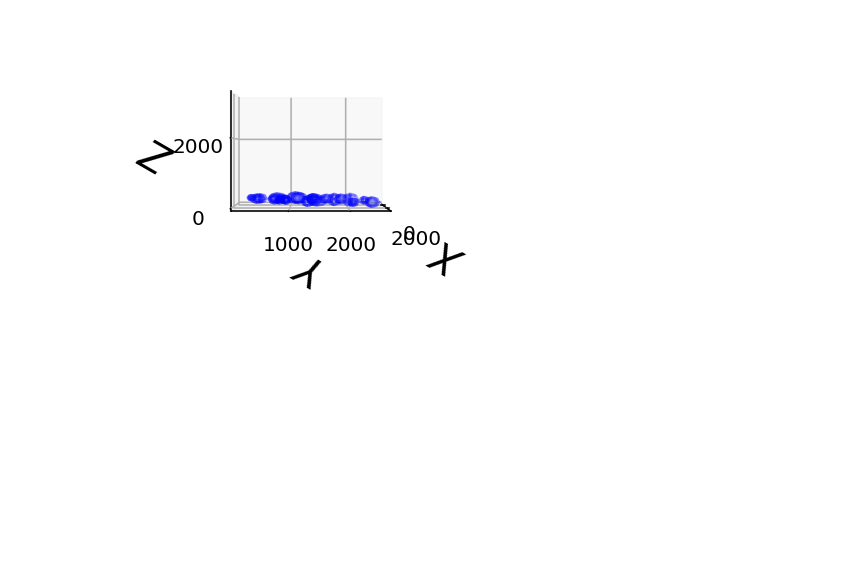

<IPython.core.display.Javascript object>


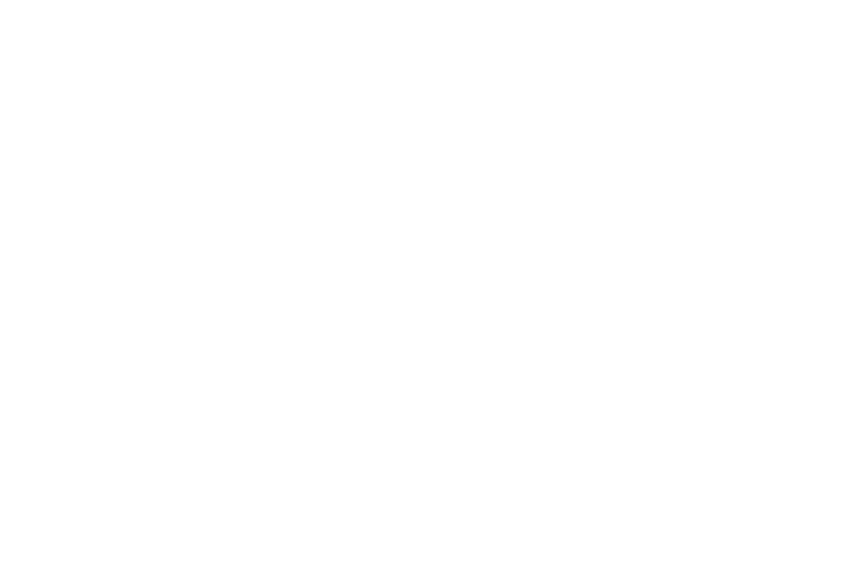

<IPython.core.display.Javascript object>


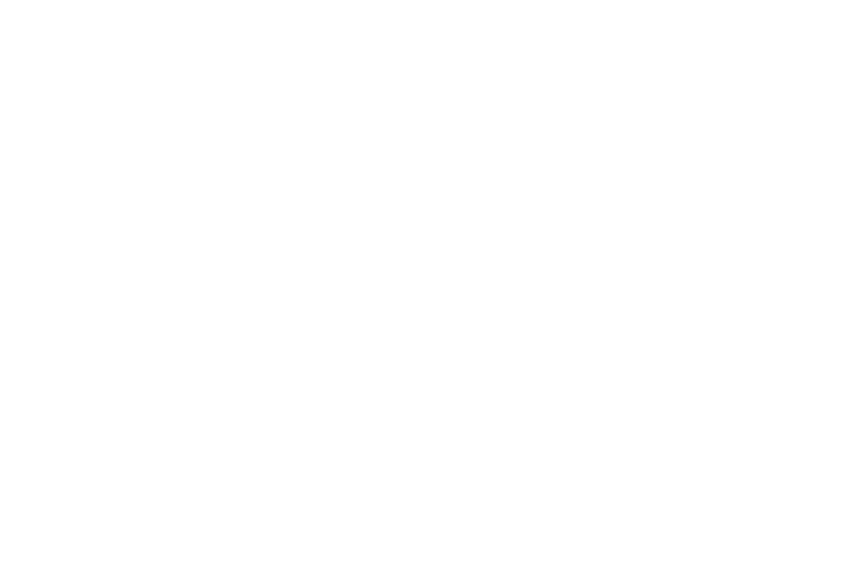

In [16]:
%matplotlib notebook

layer_render(merge_particles_1, info_1)

## 8. Combine layers and save to a text file

In [17]:
# combine_layers([merge_particles_1,merge_particles_2,merge_particles_3], [info_1, info_2, info_3], "max_c_abe.txt")
# combine_layers([merge_particles_1,merge_particles_3,merge_particles_2], [info_1, info_3, info_2], "max_c_aeb.txt")
# combine_layers([merge_particles_2,merge_particles_1,merge_particles_3], [info_2, info_1, info_3], "max_c_bae.txt")
# combine_layers([merge_particles_2,merge_particles_3,merge_particles_1], [info_2, info_3, info_1], "max_c_bea.txt")
# combine_layers([merge_particles_3,merge_particles_1,merge_particles_2], [info_3, info_1, info_2], "max_c_eab.txt")
# combine_layers([merge_particles_3,merge_particles_2,merge_particles_1], [info_3, info_2, info_1], "max_c_eba.txt")



In [18]:
print(merge_particles_1)

{2: [('x', 232.97941081446234), ('y', 293.61984903222015), ('a', 80.18736693868064), ('theta', -135.0), ('b', 62.260037566987755), ('c', 71.2237022528342)], 3: [('x', 566.0353435988912), ('y', 315.456047847643), ('a', 75.67943486441662), ('theta', -87.39743779750019)], 4: [('x', 402.1346613081717), ('y', 332.0907837769623), ('a', 60.8026538804828), ('theta', -66.69510946079689)], 5: [('x', 869.5042449969678), ('y', 418.7386294724075), ('a', 135.56744585054537), ('theta', -127.01513378474341), ('b', 96.47272878783363), ('c', 116.0200873191895)], 6: [('x', 609.0221083368094), ('y', 463.2659952724311), ('a', 125.70581072822453), ('theta', -167.76849907876982), ('b', 101.0573696608909), ('c', 113.38159019455772)], 8: [('x', 268.12581642530233), ('y', 763.2202163350844), ('a', 167.51035262537198), ('theta', -56.71743470320338), ('b', 83.5986141401655), ('c', 125.55448338276874)], 9: [('x', 1291.5677316582007), ('y', 734.959374029435), ('a', 120.58134748812886), ('theta', -49.0444855741811),

In [19]:
#combine_layers([merge_particles_2,merge_particles_3], [info_2, info_3], "two_layer_be.txt")

In [20]:
# combine_layers([merge_particles_1], [info_1], "./500nm_epoxy/500nm_epoxy_15.txt")
#combine_layers([merge_particles_2], [info_2], "layer_b.txt")
#combine_layers([merge_particles_3], [info_3], "layer_e.txt")
combine_layers([merge_particles_1], [info_1], "layer_h_again.txt")

In [21]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 157.337284727 seconds
